## Random Forest 
We start by importing a few packages. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from pathlib import Path # To make relative paths
import plotly.express as px
pd.options.display.max_columns = None
import plotly.express as px
import plotly.io as pio

import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import statistics as stat
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
# Set the color palette
color_palette = sns.color_palette("GnBu", 7)  # Define the color palette

# Example of setting the color palette globally (optional)
sns.set_palette(color_palette)

In [2]:
final_df = pd.read_parquet('ML_Dataset.parquet', engine='pyarrow')
#final_df.set_option('display.max.columns', 1000)
#final_df

#### We create a Class in which to run our Random Forest Model 
After having imported 'standard stuff' and run our dataframe, we are have all we need. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform
from scipy import stats
import os


class RandomForestOptimizer:
    def __init__(self, data, target, features, test_size=1/3, random_state=161193):
        self.data = data
        self.target = target
        self.features = features
        self.test_size = test_size
        self.random_state = random_state
        self.best_model = None
        self.feature_importance = None
        self.results = {}

    def save_plot(self, fig, filename):
        if not os.path.exists('plots'):
            os.makedirs('plots')
        fig.savefig(f'plots/{filename}')
        plt.close(fig)
        
    def preprocess_data(self):
        print("Preprocessing data...")
        X = self.data[self.features]
        y = self.data[self.target]

        # Handle categorical variables
        X = pd.get_dummies(X, drop_first=True)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

        # Handle outliers and scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test

    def optimize_model(self, n_iter=100, cv=10):
        print("Optimizing Random Forest model...")
        X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test = self.preprocess_data()

        # Define the parameter space
        param_dist = {
            'n_estimators': randint(100, 500),
            'max_depth': randint(10, 100),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': uniform(0.1, 0.9)
        }

        # Create the RandomForestRegressor
        rf = RandomForestRegressor(random_state=self.random_state)

        # Perform randomized search
        random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=n_iter, cv=cv, 
                                           scoring='neg_mean_squared_error', n_jobs=-1, random_state=self.random_state)
        random_search.fit(X_train_scaled, y_train)

        self.best_model = random_search.best_estimator_

        # Evaluate the model
        y_pred = self.best_model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        self.results['Best Parameters'] = random_search.best_params_
        self.results['MSE'] = mse
        self.results['RMSE'] = np.sqrt(mse)
        self.results['R2'] = r2

        # Feature importance
        self.feature_importance = self.get_feature_importance(X_test, y_test)

        # Learning curves
        self.plot_learning_curve(X_train_scaled, y_train)

        return self.results

    def get_feature_importance(self, X, y):
        print("Calculating feature importance...")
        perm_importance = permutation_importance(self.best_model, X, y, n_repeats=10, random_state=self.random_state)
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': perm_importance.importances_mean
        }).sort_values('importance', ascending=False)
        
        # Plot feature importance
        fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure explicitly
        sns.barplot(x='importance', y='feature', data=feature_importance.head(15), ax=ax)
        ax.set_title('Top 15 Feature Importances', fontsize=18)  # Bigger title
        ax.set_xlabel('Importance', fontsize=14)  # Bigger x-axis label
        ax.set_ylabel('Feature', fontsize=14)  # Bigger y-axis label
        plt.xticks(fontsize=12)  # Increase x-tick label size
        plt.yticks(fontsize=12)  # Increase y-tick label size
        plt.tight_layout()
        self.save_plot(fig, 'feature_importance.png')
    
        plt.show()
    
        return feature_importance

    def plot_learning_curve(self, X, y, cv=5):
        print("Generating learning curve...")
        train_sizes, train_scores, test_scores = learning_curve(
            self.best_model, X, y, cv=cv, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10), scoring="neg_mean_squared_error"
        )
        train_scores_mean = -np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)  # Corrected line
    
        fig, ax = plt.subplots(figsize=(10, 6))  # Create the figure explicitly
        ax.set_title("Learning Curve", fontsize=18)  # Bigger title
        ax.set_xlabel("Training examples", fontsize=14)  # Bigger x-axis label
        ax.set_ylabel("Mean Squared Error", fontsize=14)  # Bigger y-axis label
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax.legend(loc="best", fontsize=12)  # Adjust legend size
        plt.xticks(fontsize=12)  # Increase x-tick label size
        plt.yticks(fontsize=12)  # Increase y-tick label size
        plt.tight_layout()
        self.save_plot(fig, 'learning_curve.png')
    
        plt.show()


    def plot_residuals(self):
        print("Plotting residuals...")
        _, X_test, _, X_test_scaled, _, y_test = self.preprocess_data()
        y_pred = self.best_model.predict(X_test_scaled)
        residuals = y_test - y_pred
    
        # Set the color palette
        color_palette = sns.color_palette("GnBu", 7)  # 7 colors from the 'GnBu' palette
    
        # Residual Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(y_pred, residuals, color=color_palette[3])
        ax.set_xlabel('Predicted Values', fontsize=14, family='Georgia')
        ax.set_ylabel('Residuals', fontsize=14, family='Georgia')
        ax.set_title('Residual Plot', fontsize=18, family='Georgia')
        ax.axhline(y=0, color='r', linestyle='--')
        plt.xticks(fontsize=12, family='Georgia')
        plt.yticks(fontsize=12, family='Georgia')
        plt.tight_layout()
        self.save_plot(fig, 'residual_plot_palette.png')
    
        plt.show()
    
        # Q-Q Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        stats.probplot(residuals, dist="norm", plot=ax)
        ax.get_lines()[1].set_color('r')  # Change color of the line in Q-Q plot
        ax.set_title("Q-Q Plot", fontsize=18, family='Georgia')
        plt.xticks(fontsize=12, family='Georgia')
        plt.yticks(fontsize=12, family='Georgia')
        plt.tight_layout()
        self.save_plot(fig, 'qq_plot_palette.png')
    
        plt.show()

    def run(self):
        self.optimize_model()
        self.plot_residuals()
        print("\nOptimization Results:")
        for key, value in self.results.items():
            print(f"{key}: {value}")
        print("\nTop 15 Feature Importances:")
        print(self.feature_importance.head(10))

In [8]:
final_df = pd.read_parquet('ML_Dataset.parquet', engine='pyarrow')
#final_df.set_option('display.max.columns', 1000)
#final_df.head(2)

import os

# Create priceMil column
final_df['priceMil'] = final_df['priceCash'] / 1000000

# Define the relevant features and target variable
features = ['job_density', 'distance_to_nearest_station', 'departures_per_hour', 
            'distance_to_job_center', 'propertyType', 'energyClass', 
            'rooms', 'size', 'lotSize', 'basementSize', 'exp',
            'buildYear', 'municipality']

target = 'priceMil'

# Create a DataFrame containing only the features and the target
model_df = final_df[features + [target]].reset_index(drop=True)

# Generate dummy variables for the categorical features
model_df_dummies = pd.get_dummies(model_df, columns=['propertyType', 'energyClass', 'municipality'], drop_first=True)

# Define X (features) and y (target)
X = model_df_dummies.drop(target, axis=1)  # Features
y = model_df_dummies[target]               # Target

# Initialize the RandomForestOptimizer class with preprocessed data
optimizer_extended = RandomForestOptimizer(data=model_df_dummies, target=target, features=X.columns.tolist())

# Run the optimizer
optimizer_extended.run()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)
#print("Range of target values in the training set:", y_train.min(), "-", y_train.max())
#print("Range of target values in the test set:", y_test.min(), "-", y_test.max())
#final_df


Optimizing Random Forest model...
Preprocessing data...
Calculating feature importance...
Generating learning curve...
Plotting residuals...
Preprocessing data...

Optimization Results:
Best Parameters: {'max_depth': 16, 'max_features': 0.6040966883398536, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 202}
MSE: 2.2245440578384907
RMSE: 1.491490549027546
R2: 0.8226712225145152

Top 15 Feature Importances:
                   feature  importance
7             basementSize    0.275156
4                    rooms    0.077305
22           energyClass_D    0.032862
3   distance_to_job_center    0.003659
61      municipality_329.0    0.000000
85      municipality_561.0    0.000000
81      municipality_510.0    0.000000
82      municipality_530.0    0.000000
83      municipality_540.0    0.000000
84      municipality_550.0    0.000000


Preprocessing data...


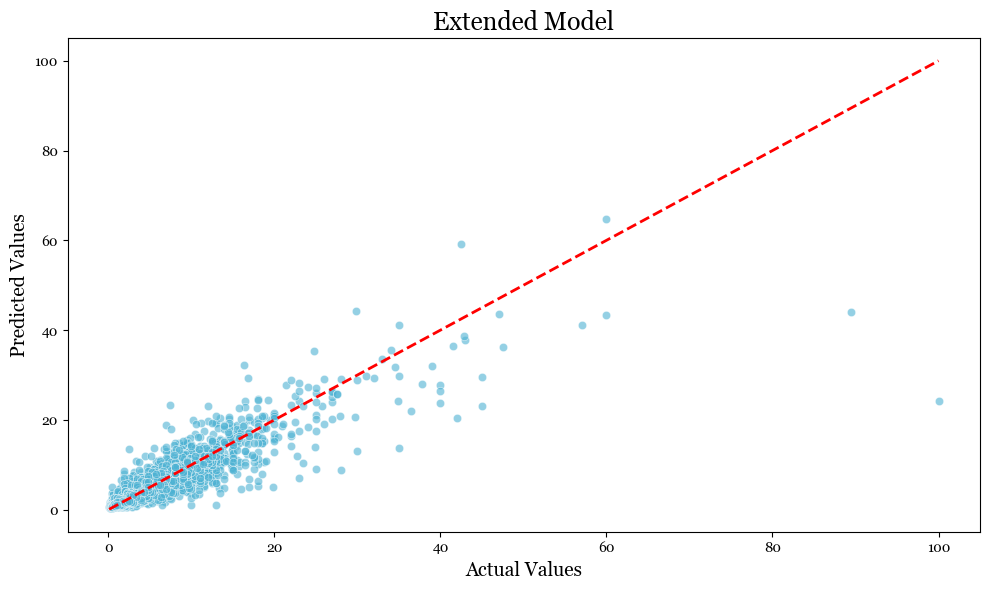

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set global graph settings
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Define the color palette (GnBu for a green to blue scale)
color_palette = sns.color_palette("GnBu", 7)  # 7 colors from the 'GnBu' palette

# Access the data and predictions
_, X_test, _, X_test_scaled, _, y_test = optimizer_extended.preprocess_data()
y_pred = optimizer_extended.best_model.predict(X_test_scaled)

# Create the plot for predictions vs. actual values
plt.figure(figsize=(10, 6))

# Use the custom color palette in the scatter plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color=color_palette[4])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Extended Model", fontsize=18)
plt.tight_layout()

# Save the plot if needed
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [7]:
final_df = pd.read_parquet('ML_Dataset.parquet', engine='pyarrow')


import os


# Create priceMil column
final_df['priceMil'] = final_df['priceCash'] / 1000000

# Define the relevant features and target variable
features = [ 'propertyType', 'energyClass', 
            'rooms', 'size', 'lotSize', 'basementSize', 'exp',
            'buildYear', 'municipality']

target = 'priceMil'

# Create a DataFrame containing only the features and the target
model_df = final_df[features + [target]].reset_index(drop=True)

# Generate dummy variables for the categorical features
model_df_dummies = pd.get_dummies(model_df, columns=['propertyType', 'energyClass', 'municipality'], drop_first=True)

# Define X (features) and y (target)
X = model_df_dummies.drop(target, axis=1)  # Features
y = model_df_dummies[target]               # Target

# Initialize the RandomForestOptimizer class with preprocessed data
optimizer_simple = RandomForestOptimizer(data=model_df_dummies, target=target, features=X.columns.tolist())

# Run the optimizer
optimizer_simple.run()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=161193)
#print("Range of target values in the training set:", y_train.min(), "-", y_train.max())
#print("Range of target values in the test set:", y_test.min(), "-", y_test.max())
#final_df


Optimizing Random Forest model...
Preprocessing data...
Calculating feature importance...
Generating learning curve...
Plotting residuals...
Preprocessing data...

Optimization Results:
Best Parameters: {'max_depth': 82, 'max_features': 0.6278806315001075, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 335}
MSE: 2.2835528301642896
RMSE: 1.5111428887316678
R2: 0.8179673581785485

Top 15 Feature Importances:
               feature  importance
3         basementSize    0.374640
17       energyClass_C    0.002186
59  municipality_336.0    0.000000
76  municipality_492.0    0.000000
88  municipality_621.0    0.000000
87  municipality_615.0    0.000000
86  municipality_607.0    0.000000
85  municipality_580.0    0.000000
84  municipality_575.0    0.000000
83  municipality_573.0    0.000000


In [42]:
def plot_residuals(self):
    print("Plotting residuals...")
    _, X_test, _, X_test_scaled, _, y_test = self.preprocess_data()
    y_pred = self.best_model.predict(X_test_scaled)
    residuals = y_test - y_pred

    # Set the color palette
    color_palette = sns.color_palette("GnBu", 7)  # 7 colors from the 'GnBu' palette

    # Residual Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(y_pred, residuals, color=color_palette[3])
    ax.set_xlabel('Predicted Values', fontsize=14, family='Georgia')
    ax.set_ylabel('Residuals', fontsize=14, family='Georgia')
    ax.set_title('Residual Plot', fontsize=18, family='Georgia')
    ax.axhline(y=0, color='r', linestyle='--')
    plt.xticks(fontsize=12, family='Georgia')
    plt.yticks(fontsize=12, family='Georgia')
    plt.tight_layout()
    self.save_plot(fig, 'residual_plot_extended_palette.png')

    plt.show()

    # Q-Q Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.get_lines()[1].set_color('r')  # Change color of the line in Q-Q plot
    ax.set_title("Q-Q Plot", fontsize=18, family='Georgia')
    plt.xticks(fontsize=12, family='Georgia')
    plt.yticks(fontsize=12, family='Georgia')
    plt.tight_layout()
    self.save_plot(fig, 'qq_plot_extended_palette.png')

    plt.show()

# Calling the plot_residuals function
optimizer_extended.plot_residuals()


Plotting residuals...
Preprocessing data...


Preprocessing data...


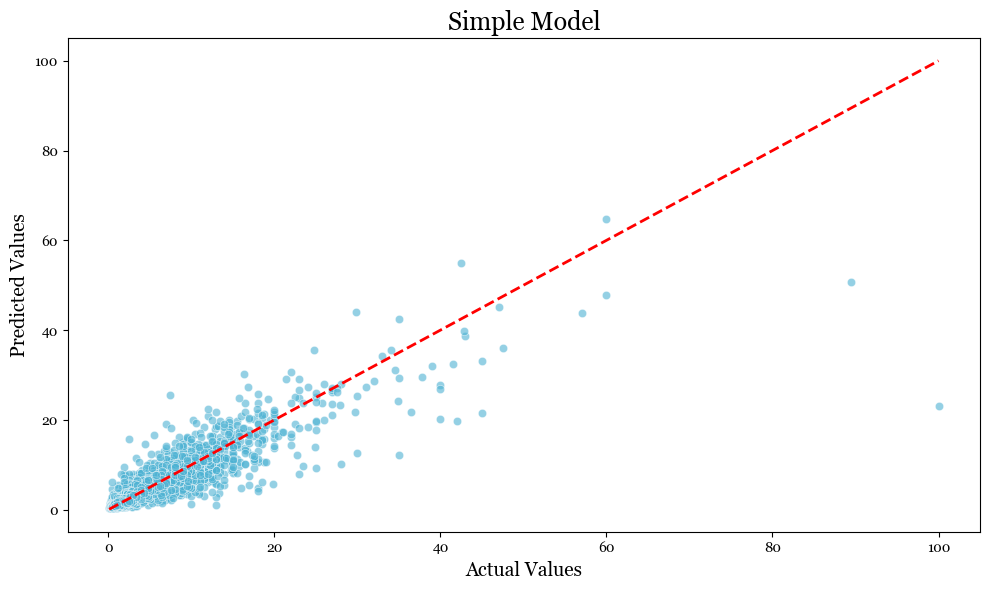

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set global graph settings
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Define the color palette (GnBu for a green to blue scale)
color_palette = sns.color_palette("GnBu", 7)  # 7 colors from the 'GnBu' palette

# After running the model, access the data and predictions
_, X_test, _, X_test_scaled, _, y_test = optimizer_simple.preprocess_data()
y_pred = optimizer_simple.best_model.predict(X_test_scaled)

# Now, create the plot for predictions vs. actual values
plt.figure(figsize=(10, 6))

# Use the custom color palette in the scatter plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color=color_palette[4])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Simple Model", fontsize=18)
plt.tight_layout()

# Save the plot if needed
plt.savefig('predictions_vs_actual_simple_model.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Preprocessing data...
Preprocessing data...


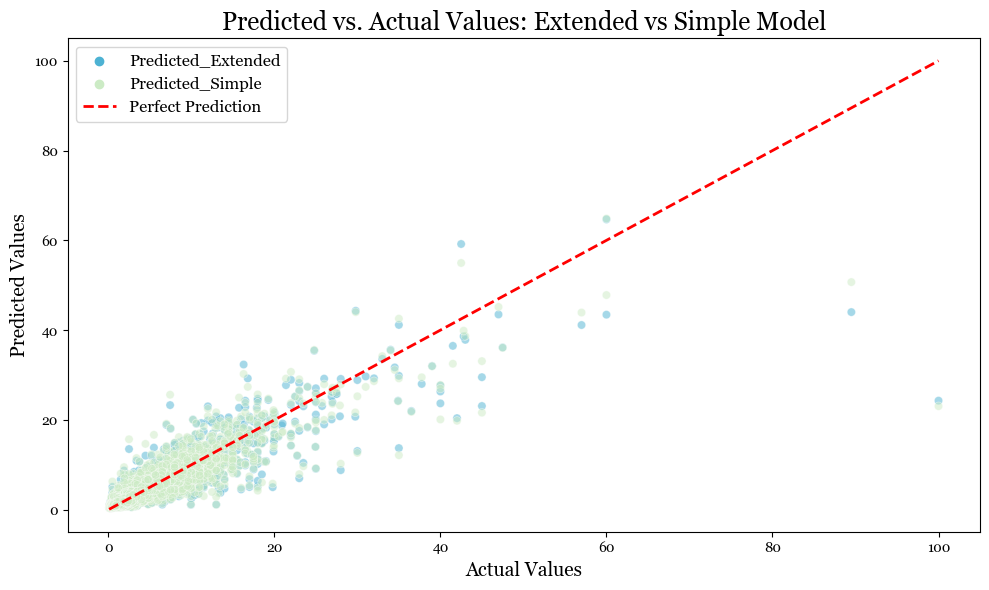

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set global graph settings
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Choose colors that are farther apart in the 'GnBu' palette
color_palette = sns.color_palette("GnBu", 7)
distinct_colors = [color_palette[4], color_palette[1]]  # Select two distinct colors from the palette

# Get data and predictions from both models
_, X_test_ext, _, X_test_scaled_ext, _, y_test_ext = optimizer_extended.preprocess_data()
y_pred_ext = optimizer_extended.best_model.predict(X_test_scaled_ext)

_, X_test_simple, _, X_test_scaled_simple, _, y_test_simple = optimizer_simple.preprocess_data()
y_pred_simple = optimizer_simple.best_model.predict(X_test_scaled_simple)

# Combine the predictions and actual values into a DataFrame
data_combined = pd.DataFrame({
    'Actual': y_test_ext,  # Assuming y_test is the same for both models
    'Predicted_Extended': y_pred_ext,
    'Predicted_Simple': y_pred_simple
})

# Melt the DataFrame to long format for easy plotting with hue
data_melted = data_combined.melt(id_vars=['Actual'], value_vars=['Predicted_Extended', 'Predicted_Simple'], 
                                 var_name='Model', value_name='Predicted')

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', hue='Model', palette=distinct_colors, data=data_melted, alpha=0.5)

# Add the perfect prediction line
plt.plot([data_melted['Actual'].min(), data_melted['Actual'].max()], 
         [data_melted['Actual'].min(), data_melted['Actual'].max()], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Actual Values: Extended vs Simple Model", fontsize=18)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('predictions_vs_actual_combined.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


Preprocessing data...


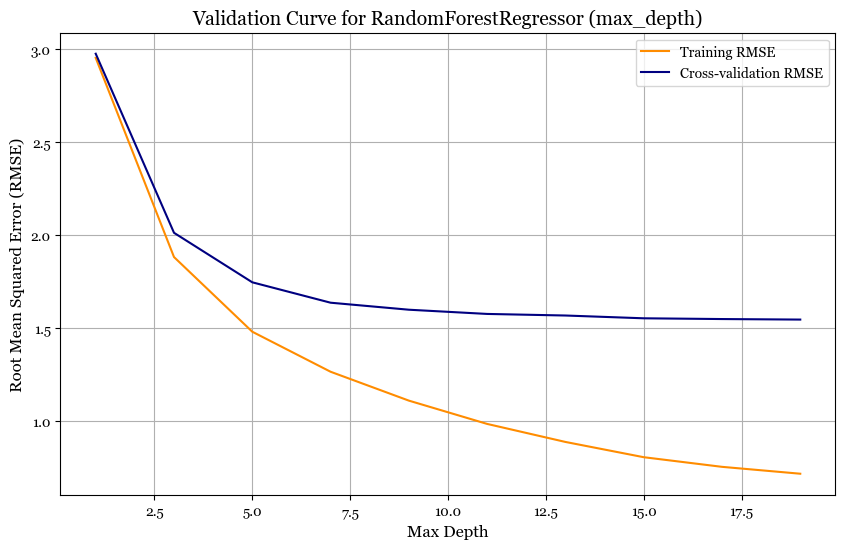

In [37]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Preprocess the data using the optimizer
_, _, X_train_scaled, _, y_train, _ = optimizer_extended.preprocess_data()

# Define the range of values for the max_depth parameter
max_depth_range = np.arange(1, 20, 2)

# Generate validation curves
train_scores, test_scores = validation_curve(
    estimator=optimizer_extended.best_model,
    X=X_train_scaled,
    y=y_train,
    param_name='max_depth',
    param_range=max_depth_range,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation of the scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plotting the validation curves
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, np.sqrt(train_scores_mean), label="Training RMSE", color="darkorange")
plt.plot(max_depth_range, np.sqrt(test_scores_mean), label="Cross-validation RMSE", color="navy")
plt.title("Validation Curve for RandomForestRegressor (max_depth)")
plt.xlabel("Max Depth")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend(loc="best")
plt.grid(True)
plt.savefig('validation_curve_max_depth.png', dpi=300, bbox_inches='tight')
plt.show()


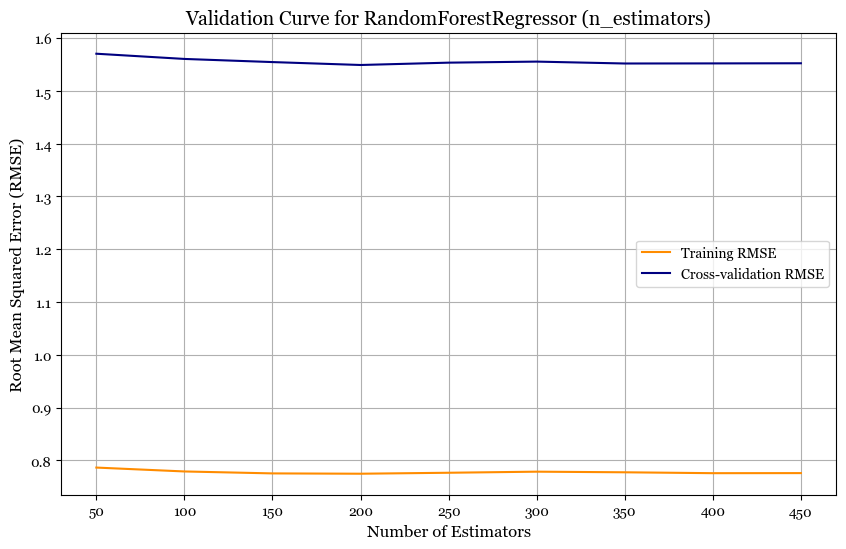

In [38]:
# Define the range of values for the n_estimators parameter
n_estimators_range = np.arange(50, 500, 50)

# Generate validation curves
train_scores, test_scores = validation_curve(
    estimator=optimizer_extended.best_model,
    X=X_train_scaled,
    y=y_train,
    param_name='n_estimators',
    param_range=n_estimators_range,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate mean and standard deviation of the scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plotting the validation curves
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, np.sqrt(train_scores_mean), label="Training RMSE", color="darkorange")
plt.plot(n_estimators_range, np.sqrt(test_scores_mean), label="Cross-validation RMSE", color="navy")
plt.title("Validation Curve for RandomForestRegressor (n_estimators)")
plt.xlabel("Number of Estimators")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend(loc="best")
plt.grid(True)
plt.savefig('validation_curve_n_estimators.png', dpi=300, bbox_inches='tight')
plt.show()


Preprocessing data...
Generating validation curve for n_estimators...


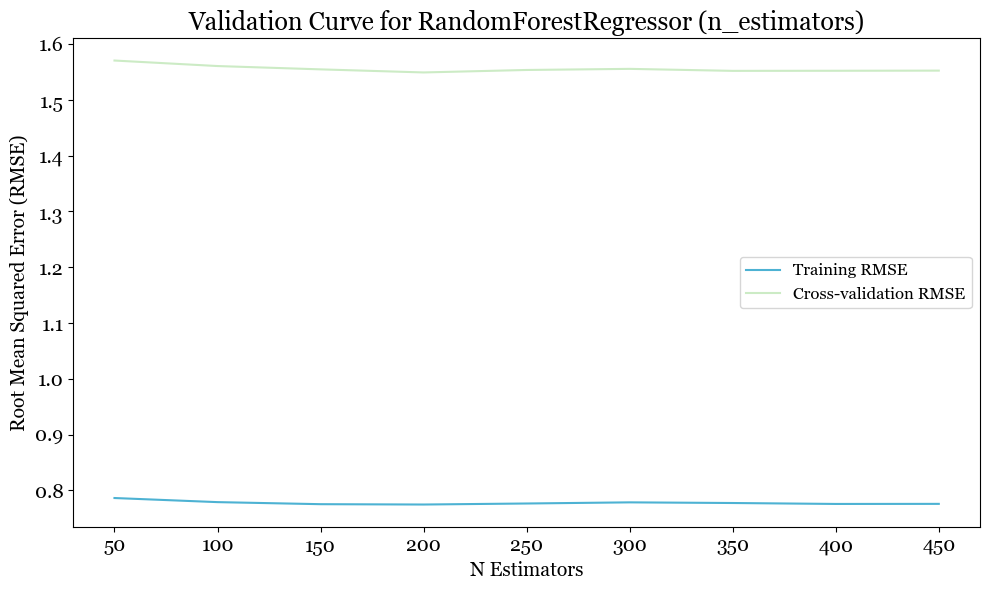

Generating validation curve for max_depth...


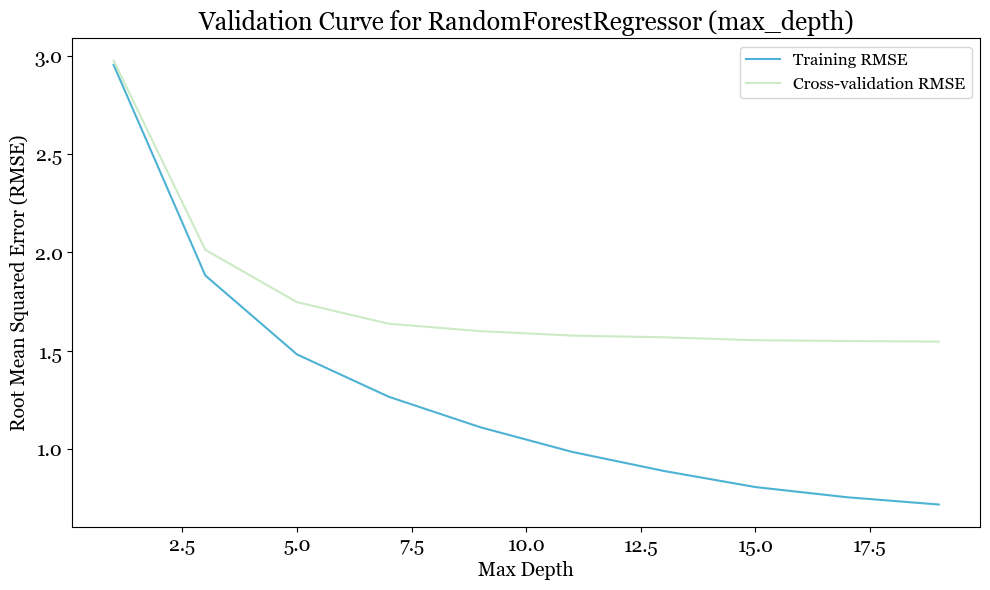

Generating validation curve for min_samples_split...


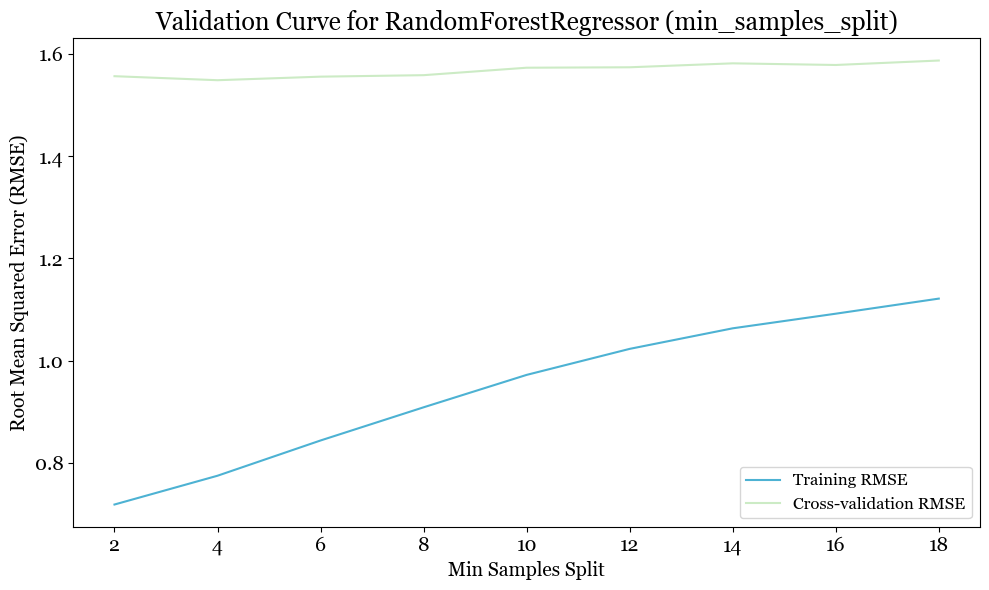

Generating validation curve for min_samples_leaf...


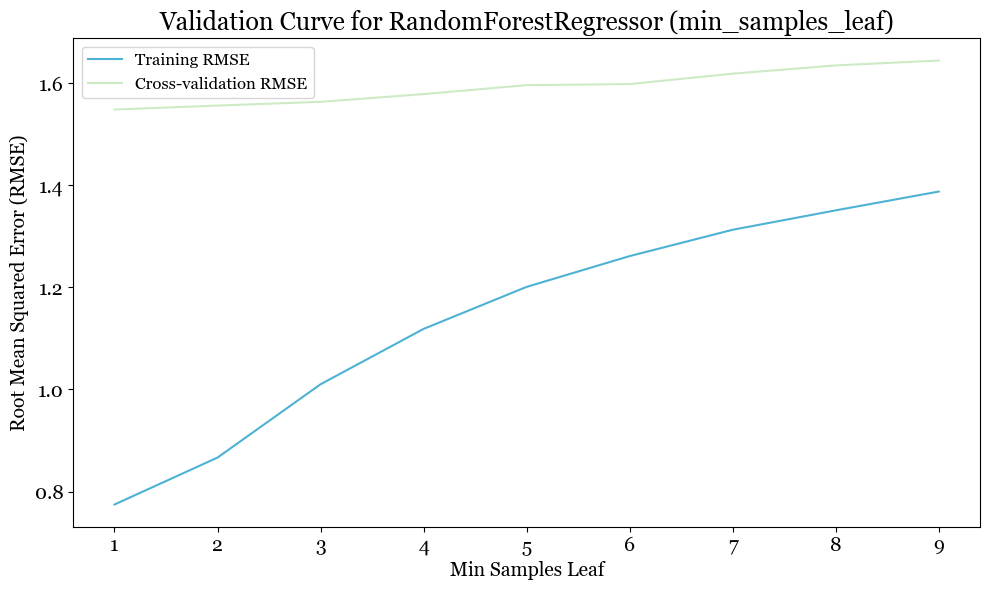

Generating validation curve for max_features...


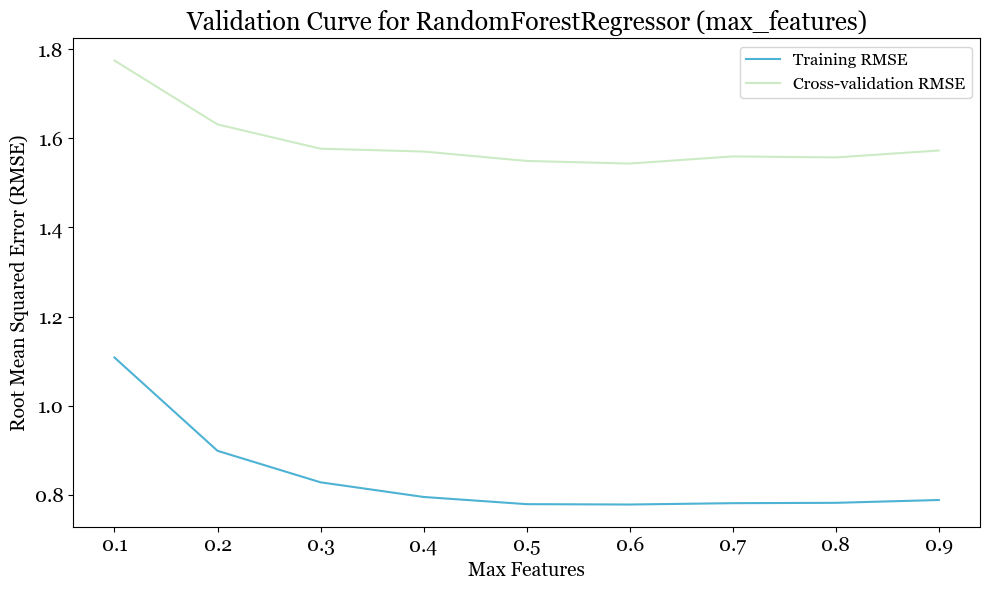

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Assuming optimizer_extended is already run and has the best model
# Example: optimizer_extended.best_model

# Set global graph settings
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Choose colors that are farther apart in the 'GnBu' palette
color_palette = sns.color_palette("GnBu", 7)
distinct_colors = [color_palette[4], color_palette[1]]  # Select two distinct colors from the palette

# Preprocess the data using the optimizer
_, _, X_train_scaled, _, y_train, _ = optimizer_extended.preprocess_data()

# List of hyperparameters to evaluate
param_names = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
param_ranges = {
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': np.arange(1, 20, 2),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 10, 1),
    'max_features': np.linspace(0.1, 0.9, 9)
}

# Iterate over each hyperparameter and create validation curves
for param_name in param_names:
    print(f"Generating validation curve for {param_name}...")
    
    # Generate validation curves
    train_scores, test_scores = validation_curve(
        estimator=optimizer_extended.best_model,
        X=X_train_scaled,
        y=y_train,
        param_name=param_name,
        param_range=param_ranges[param_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Calculate mean and standard deviation of the scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    # Plotting the validation curves
    plt.figure(figsize=(10, 6))
    plt.plot(param_ranges[param_name], np.sqrt(train_scores_mean), label="Training RMSE", color=distinct_colors[0])
    plt.plot(param_ranges[param_name], np.sqrt(test_scores_mean), label="Cross-validation RMSE", color=distinct_colors[1])
    plt.title(f"Validation Curve for RandomForestRegressor ({param_name})", fontsize=18)
    plt.xlabel(param_name.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=14)
    plt.legend(loc="best", fontsize=12)
    plt.grid(False)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'validation_curve_{param_name}.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()
